In [238]:
import tp3
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pandas as pd
from faker import Faker
import time 

In [239]:
NAME_SIZE = 40
SUBSETS_SIZE = 190

In [240]:
fake = Faker()
nombres_aleatorios = set()
nombres_aleatorios_list  = []
while len(nombres_aleatorios) < NAME_SIZE:
    nombre = fake.name()
    nombres_aleatorios.add(nombre)

nombres_aleatorios_list = list(nombres_aleatorios)

In [241]:
subsets = []
for i in range(SUBSETS_SIZE): 
    subset = []
    for j in range(i): 
        new_set = set()
        for k in range(random.randint(1, NAME_SIZE)):
            pos = random.randint(1, NAME_SIZE - 1)
            new_set.add(nombres_aleatorios_list[pos])
        subset.append(new_set)
    subsets.append(subset)

In [242]:
times = pd.DataFrame()

In [243]:
def calcular_tiempos(subsets, bt_func, lp_func, a):    
    time_list_bt = []  
    time_list_lp = []
    lengths = []    
    for i in range(len(subsets)):
        
        bt_time_i = time.time()
        bt_sol = bt_func(subsets[i], a)
        bt_time_e = time.time()
        elapsed_time_bt = bt_time_e - bt_time_i

        lp_time_i = time.time()
        lp_sol = lp_func(subsets[i], a)
        lp_time_e = time.time()
        elapsed_time_lp = lp_time_e - lp_time_i
        
        if (len(bt_sol) != len(lp_sol)):
            print(bt_sol)
            print()
            print(lp_sol)
            print()
            print(subsets[i])

        time_list_bt.append(elapsed_time_bt)
        time_list_lp.append(elapsed_time_lp)

        lengths.append(len(subsets[i]))

    return time_list_bt, time_list_lp, lengths

In [244]:
bt_time, lp_time, lengths = calcular_tiempos(subsets, tp3.search_for_min_hitting_set, tp3.search_hs_linealp, nombres_aleatorios)

set()

{'Sarah_Smith'}

[{'Hannah Castro', 'John Roy', 'Patricia Gray', 'Lisa Garcia', 'Mr. Benjamin Roman', 'Antonio Bowen', 'Robert Marshall', 'Michelle Higgins', 'Brenda Hendricks', 'Jessica Edwards', 'Sarah Smith', 'Patricia Preston', 'Glenn Mcintyre', 'Joshua Brown', 'Jonathan Thompson', 'Philip Skinner'}]
set()

{'Karina_Williams', 'Glenn_Mcintyre', 'Taylor_Larson', 'Lisa_Garcia', 'Matthew_Johnson', 'Hannah_Castro', 'Mr._Benjamin_Roman', 'Kristy_Brooks', 'Kristy_Daniels', 'Nancy_Miller', 'Jessica_Edwards', 'Patricia_Preston', 'Frank_Palmer', 'Jason_Jordan'}

[{'Christine Frank', 'Patricia Gray', 'Michelle Higgins', 'Brenda Hendricks', 'Nancy Miller', 'Kevin Jones', 'Patricia Preston', 'Joshua Brown', 'Kim Bennett'}, {'Kristy Daniels', 'Kim Bennett'}, {'Troy Adams', 'Mr. Benjamin Roman'}, {'Karina Williams', 'Lisa Garcia', 'Robert Marshall', 'Michael Mendez', 'Kayla Clark', 'John Roy', 'Jonathan Thompson', 'Jordan Walls'}, {'Frank Palmer', 'Christine Frank', 'Taylor Spencer', 'Sar

Text(0.5, 0, 'Cantidad de conjuntos')

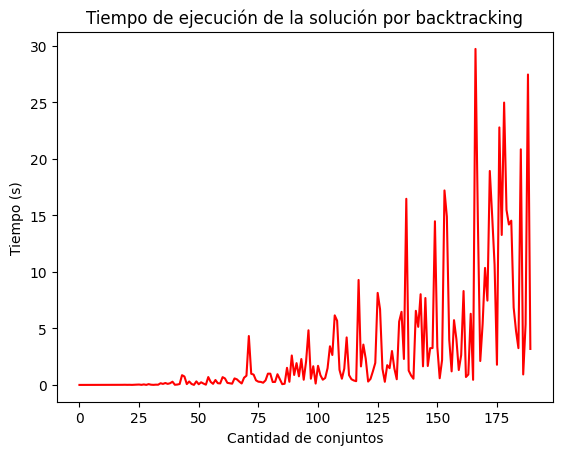

In [245]:
plt.plot(lengths, bt_time, label='linealp', color='red')
plt.title('Tiempo de ejecución de la solución por backtracking')
plt.ylabel('Tiempo (s)')
plt.xlabel('Cantidad de conjuntos')

Text(0.5, 0, 'Cantidad de conjuntos')

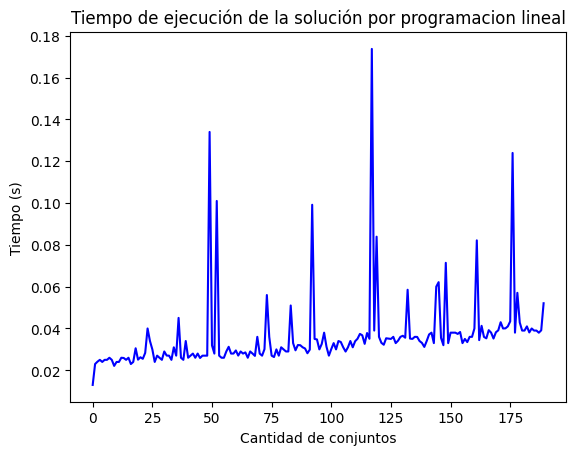

In [246]:
plt.plot(lengths, lp_time, label='linealp', color='blue')
plt.title('Tiempo de ejecución de la solución por programacion lineal')
plt.ylabel('Tiempo (s)')
plt.xlabel('Cantidad de conjuntos')

Text(0.5, 0, 'Cantidad de conjuntos')

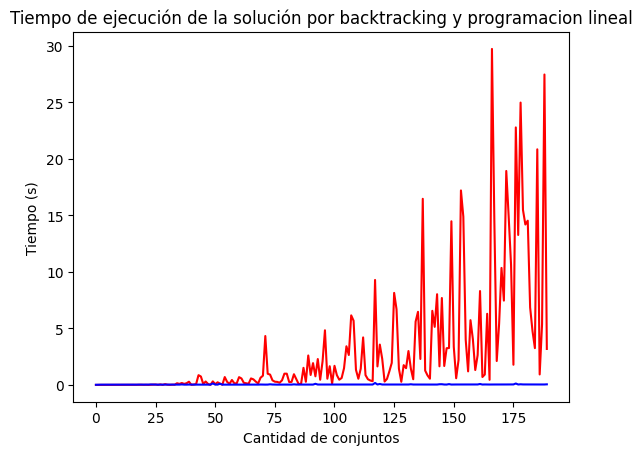

In [247]:
plt.plot(lengths, bt_time, label='backtracking', color='red')
plt.plot(lengths, lp_time, label='linealp', color='blue')
plt.title('Tiempo de ejecución de la solución por backtracking y programacion lineal')
plt.ylabel('Tiempo (s)')
plt.xlabel('Cantidad de conjuntos')